# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from numba import njit
from photutils import segmentation as segm
from scipy.spatial import ConvexHull

## 2. Read data

### select one dataset:

In [2]:
dataset = 3

1D spectra

2D images:

In [3]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [4]:
if dataset == 2:
    hdu = fits.open('data/CIG_335.fits')
    data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

3D datacubes:

In [5]:
if dataset == 3:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### visual inspection:

In [6]:
data_dimensionality = len(data.shape)

In [7]:
if data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data')
    ax = fig.subplots()

    im = ax.imshow(data,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95),
                  )
    ax.set_title('Input data')
    cb = fig.colorbar(im, ax=ax)

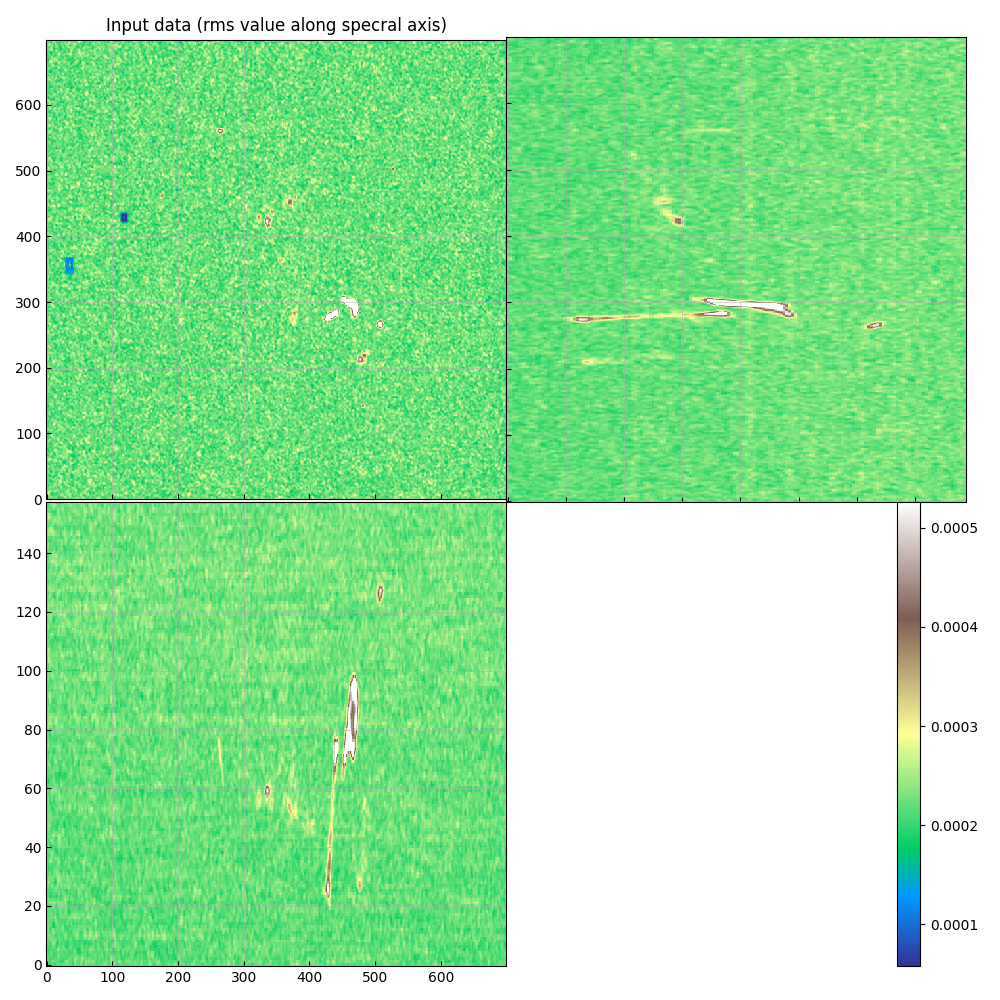

In [8]:
if data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    lo = np.nanpercentile(data, 60)
    hi = np.nanpercentile(data, 99)

    im = ax[0, 0].imshow(np.sqrt(np.nanmean(data**2, axis=0)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 0].set_title('Input data (rms value along specral axis)')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(data**2, axis=2)).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(data**2, axis=1)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_aspect('auto')
    
    cb = fig.colorbar(im, ax=ax[1, 1])
    ax[1, 1].set_visible(False)

## 3. Find mode

### number density and cumulative fraction:

Note: I removed the possibility of statistical weights.

In [9]:
sorted_data = np.sort(data.flatten())
sorted_data = np.hstack([sorted_data[0], (sorted_data[1:]+sorted_data[:-1])/2, sorted_data[-1]])
number_fraction = np.arange(data.size+1)/data.size

And I had to downsaple, both for smoothing as well as to avoid numerical problems (CPU time, and even crashes due to the memory required by the plots) 

In [10]:
d50 = sorted_data[data.size//2]
print(f'Data median: {d50:.3g}')
bg_std = np.std(sorted_data[:data.size//2])
print(f'First guess of background standard deviation: {bg_std:.3g}')
data_std = np.std(data)

d_left = sorted_data[1]
d_right = 2*d50 - d_left
n_steps = int(100*(d_right-d_left)/bg_std)
data_sample = np.linspace(d_left, d_right, n_steps)
print(f'Data subsampled to {n_steps} linear steps between {d_left:.3g} and {d_right:.3g}')

Data median: 6.64e-07
First guess of background standard deviation: 0.000135
Data subsampled to 1832 linear steps between -0.00124 and 0.00124


Smooth density field:

In [11]:
h_smooth = bg_std
m_left = np.interp(data_sample-h_smooth/2, sorted_data, number_fraction)
m_right = np.interp(data_sample+h_smooth/2, sorted_data, number_fraction)
data_sample_rho = (m_right-m_left) / h_smooth

### density mode:

Naive method:

In [12]:
data_mode = data_sample[np.argmax(data_sample_rho)]
print(f'Navive mode:{data_mode:.3g}')

Navive mode:2.7e-06


More stable:

In [13]:
weight = data_sample_rho**10
data_mode = np.sum(data_sample*weight) / np.sum(weight)
print(f'More stable:{data_mode:.3g}')

More stable:6.03e-07


### signal / background classification

In [14]:
rho_sym = np.interp(2*data_mode-data_sample, data_sample, data_sample_rho, left=0)
probability_bg = np.clip(rho_sym/data_sample_rho, 0, 1)
src_probability_map = 1 - np.interp(data, data_sample, probability_bg)

In [15]:
index_mode = np.searchsorted(sorted_data, data_mode)
total_flux_below_mode = np.sum(data_mode-sorted_data[:index_mode])
flux_above_mode = np.cumsum(sorted_data[index_mode:]-data_mode)
flux_threshold = np.interp(total_flux_below_mode, flux_above_mode, sorted_data[index_mode:])
print(data_mode, total_flux_below_mode, flux_threshold)

6.034007526275406e-07 6931.671 0.0005146877374500036


In [16]:
N_mode = np.count_nonzero(data < data_mode)
N_src = np.sum(src_probability_map)
N_background = data.size-N_src
print(f'{N_mode} ({100*N_mode/data.size:.1f}%) pixels below mode')
print(f'{N_background} ({100*N_background/data.size:.1f}%) background pixels; N_background/N_mode={N_background/N_mode}')
print(f'{data.size-N_background} ({100-100*N_background/data.size:.1f}%) source pixels; N_pixels-2N_mode={data.size-2*N_mode}')

threshold_guess = sorted_data[int(N_background)]
delta_th = threshold_guess-data_mode
print(f'data_mode={data_mode:.3g}, threshold_guess={threshold_guess:.3g}, delta_th={delta_th:.3g}')
bg_std = np.std(data[data < data_mode])
print(f'background std={bg_std:.3g} => delta_th={delta_th/bg_std:.3g} sigmas')


38701750 (50.0%) pixels below mode
77373717.28940658 (99.9%) background pixels; N_background/N_mode=1.999230455713413
46282.71059341729 (0.1%) source pixels; N_pixels-2N_mode=16500
data_mode=6.03e-07, threshold_guess=0.000766, delta_th=0.000766
background std=0.000135 => delta_th=5.65 sigmas


Text(0.5, 0, 'data value')

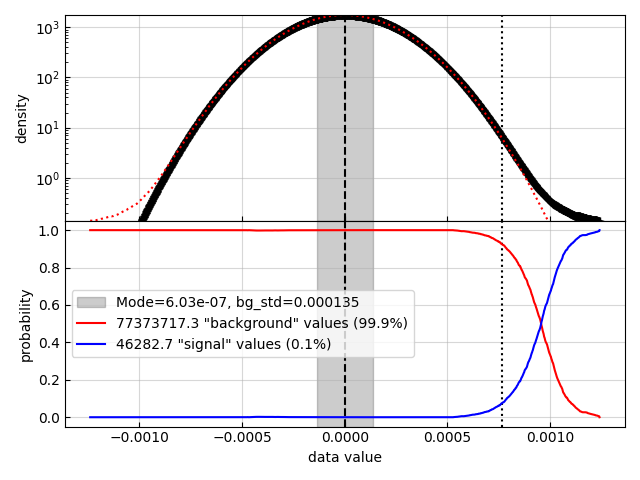

In [41]:
plt.close('density')
fig = plt.figure('density')
ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                  sharex='col', sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
    axis.set_aspect('auto')
    axis.axvline(data_mode, c='k', ls='--')
    axis.axvline(threshold_guess, c='k', ls=':')
    axis.fill_between(data_sample, 0, 1, where=np.abs(data_sample-data_mode) <= bg_std,
                      color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                      label=f'Mode={data_mode:.3g}, bg_std={bg_std:.3g}')
fig.set_tight_layout(True)

ax[0, 0].set_ylabel('density')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(np.min(data_sample_rho[data_sample > data_mode]), np.max(data_sample_rho))
ax[0, 0].plot(data_sample, data_sample_rho, 'k+', label='total')
ax[0, 0].plot(data_sample, rho_sym, 'r:', label='background')

ax[1, 0].set_ylabel('probability')
#ax[1, 0].set_yscale('log')
ax[1, 0].plot(data_sample, probability_bg, 'r-',
              label=f'{N_background:.1f} "background" values ({100*N_background/data.size:.1f}%)')
ax[1, 0].plot(data_sample, 1-probability_bg, 'b-',
              label=f'{data.size-N_background:.1f} "signal" values ({100-100*N_background/data.size:.1f}%)')
ax[1, 0].legend()

#ax[-1, 0].set_xlim(x_f[0], data_mode+5*delta_th)
ax[-1, 0].set_xlabel('data value')


In [18]:
if data_dimensionality == 2:
    plt.close('bg_map')
    fig = plt.figure('bg_map', figsize=(10, 5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=data_mode-3*bg_std, linthresh=threshold_guess, vmax=np.nanpercentile(data, 99.9)),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(data_mode, c='k', ls='--')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls=':')

    ax[0, 1].set_title('Source probability map')
    im = ax[0, 1].imshow(
        src_probability_map,
        interpolation='nearest', origin='lower', cmap='terrain',
        )
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(1-np.min(src_probability_map[data < threshold_guess]), c='k', ls=':')


## 3. Hierarchical Overdensity Tree (HOT)

### routine definition:

$$ S = \sum p_i (I_i - I_0) $$
$$ \sigma^2 = 2\sigma_0^2 \sum p_i $$

$$ n = \sum p_i $$
$$ \Delta S_n = p_n I_n + (n-1) I_{n-1} - n I_n = (p_n - 1) I_n + (n-1) (I_{n-1}-I_n) $$
$$ \Delta S_n > 0 ~~ \iff ~~ I_n < \frac{n-1}{1-p_n} I_{n-1} ~;~ 1-p_n < (n-1) \frac{I_{n-1}}{I_n} $$

$$ \Delta \sigma^2_i = p_i 2\sigma_0^2 $$

$$ \Delta \ln(S/N)^2 \sim \frac{(S+\Delta S)^2}{\sigma^2 + \Delta \sigma^2 } \frac{\sigma^2}{S^2} $$
$$ \propto \frac{S^2+p^2I^2+2pI}{1 + p } $$

In [19]:
HOT_threshold = delta_th

In [20]:
@njit
def hot(data, src_probability, threshold=-np.inf):
    """Hierarchical Overdenity Tree (HOT)"""

    flat_data = data.flatten()
    strides = np.array(data.strides)//data.itemsize

    label = np.zeros(data.size, dtype=np.int64)
    n_labels = 0
    parent = np.zeros(data.size, dtype=np.int64)
    area = np.zeros(data.size, dtype=np.int64)
    #probability = np.zeros_like(src_probability)
    max_value = np.full(data.size, threshold, dtype=data.dtype)
    min_value = np.full(data.size, threshold, dtype=data.dtype)

    for pixel in np.argsort(flat_data)[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        src_probability[pixel]
        if np.isnan(pixel_value):
            continue
        if pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < flat_data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
            max_value[n_labels] = pixel_value
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent
                min_value[p] = pixel_value

        label[pixel] = selected_parent
        area[selected_parent] += 1
        #probability[selected_parent] += src_probability[pixel]
        min_value[selected_parent] = pixel_value
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_value[:n_labels+1],
               min_value[:n_labels+1],
               #probability[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### selection based on inverted image:

In [21]:
src_probability_inv = 1 - np.interp(2*data_mode-data, data_sample, probability_bg)
label_inv, catalog_inv = hot(data_mode-data, src_probability_inv.flatten(), HOT_threshold)
parent_inv = catalog_inv[0]
area_inv = catalog_inv[1]
max_value_inv = catalog_inv[2]
min_value_inv = catalog_inv[3]


7005 overdensities found: 25119 "pixels" (0%), 6299 independent regions


Compute the upper hull of the inverted catalogue:

In [22]:
def upper_hull(x, y):
    """Compute upper hull"""
    
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]


#good_hull = (area_inv > 0)
#log_area_inv = np.log(area_inv[good_hull])
#contrast = max_value_inv[good_hull]-min_value_inv[good_hull]
log_area_inv = np.log(area_inv[1:])
contrast = max_value_inv[1:]-min_value_inv[1:]

contrast_hull_x, contrast_hull_y = upper_hull(log_area_inv, contrast)

### analysis of the normal image:

In [23]:
label, catalog = hot(data-data_mode, src_probability_map.flatten(), HOT_threshold)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_value = catalog[2]
min_value = catalog[3]


7246 overdensities found: 46284 "pixels" (0%), 6430 independent regions


In [24]:
true_overdensity = max_value-min_value > np.interp(np.log(area), contrast_hull_x, contrast_hull_y, right=0)
#true_overdensity = (max_value-min_value > delta_th)
#true_overdensity &= (area > 3)
true_overdensity[0] = False
print(f'{np.count_nonzero(true_overdensity)} overdensities pass the selection criteria')

32 overdensities pass the selection criteria


(7.6018040999770164e-06, 0.016643070894202586)

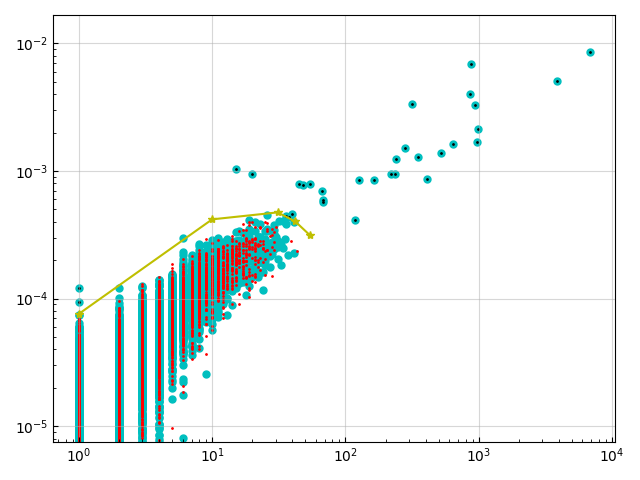

In [25]:
plt.close('catalogue_selection')
fig = plt.figure('catalogue_selection')
ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                  sharex=True, sharey='row',
                  gridspec_kw={'hspace': 0, 'wspace': 0})
for axis in ax.flatten():
    axis.tick_params(which='both', direction='in')
    axis.grid(alpha=.5)
fig.set_tight_layout(True)

#ax[0, 0].axhline(delta_th, c='k', ls=':')
ax[0, 0].scatter(area[1:], max_value[1:]-min_value[1:], s=25, c='c')
ax[0, 0].scatter(area[true_overdensity],
                 max_value[true_overdensity]-min_value[true_overdensity], s=1, c='k')
ax[0, 0].plot(np.exp(contrast_hull_x), contrast_hull_y, 'y-*')
ax[0, 0].scatter(area_inv[1:], max_value_inv[1:]-min_value_inv[1:], s=1, c='r')
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(np.min(contrast_hull_y[contrast_hull_y > 0])/10)


## 4. Clean-up

### prune HOT based on selection threshold

In [26]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        break

pruned_labels[~pruned_OK] = 0
pruned_segmentation = segm.SegmentationImage(pruned_labels[label])

7215 yet to go


In [27]:
if data_dimensionality == 2:
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data-data_mode,
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        segmentation,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    ax[1, 0].set_title('Contrast')
    im = ax[1, 0].imshow(
        max_value[label]-min_value[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('Saddle value')
    im = ax[1, 1].imshow(
        saddle_value[label],
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### mode filter

In [28]:
@njit
def mode_filter(data):
    flat_data = data.flatten()
    mode = np.empty_like(flat_data)
    count = np.empty_like(flat_data)
    strides = np.array(data.strides)//data.itemsize
    neighbours = np.empty(2*len(strides)+1, dtype=np.int64)
    counts = np.empty_like(neighbours)
    n_changes = 0
    
    for pixel in range(flat_data.size):
        #print('>', pixel)
        neighbours[0] = flat_data[pixel]
        counts[0] = 1
        n_neighbours = 1
        for stride in strides:
            if pixel >= stride:
                #print(-stride)
                value = flat_data[pixel-stride]
                n = 0
                while True:
                    if value == neighbours[n]:
                        counts[n] += 1
                        break
                    else:
                        n += 1
                        if n == n_neighbours:
                            neighbours[n] = value
                            counts[n] = 1
                            n_neighbours += 1
                            break
            if pixel+stride < flat_data.size:
                value = flat_data[pixel+stride]
                #print(stride, value)
                n = 0
                while True:
                    if value == neighbours[n]:
                        counts[n] += 1
                        break
                    else:
                        n += 1
                        if n == n_neighbours:
                            neighbours[n] = value
                            counts[n] = 1
                            n_neighbours += 1
                            break
        best = np.argmax(counts[:n_neighbours])
        if counts[best] == counts[0]: # just in case
            best = 0
        else:
            n_changes += 1
        #print(f'> pixel {pixel} moves from {neighbours[0]} to {neighbours[best]} (out of {n_neighbours} possibilities)')
        mode[pixel] = neighbours[best]
        count[pixel] = counts[best]
        
    return mode.reshape(data.shape), count.reshape(data.shape), n_changes


In [29]:
filtered_labels = pruned_labels[label]
'''
n_old = 0
n = filtered_labels.size
while n != n_old:
    n_old = n
    filtered_labels, c, n = mode_filter(filtered_labels)
    print(n, 'changes')
'''

"\nn_old = 0\nn = filtered_labels.size\nwhile n != n_old:\n    n_old = n\n    filtered_labels, c, n = mode_filter(filtered_labels)\n    print(n, 'changes')\n"

### discard residual background pixels

In [30]:
'''
N_null_label = np.count_nonzero(filtered_labels == 0)
print(f'Remember, we expected {N_background:.1f} pixels, and we have found {N_null_label}')
if N_null_label >= N_background:
    print(f'We are all set (actually, we only found {data.size-N_null_label} out of the {data.size-N_background:1} expected signal)')
    final_threshold = threshold_guess
else:
    N_discard = int(N_background-N_null_label)
    labelled_values = np.sort(data[filtered_labels > 0])
    final_threshold = labelled_values[N_discard]
    print(f'We must discard {N_discard} values, imposing a threshold {final_threshold:.3g} ({(final_threshold-data_mode)/bg_std:.1f} sigma)')
    print(f'compared to the inital guess: ({threshold_guess:.3g}-{data_mode:.3g})/{bg_std:.3g} = {threshold_guess/bg_std:.3g} sigma')
    filtered_labels[data < threshold_guess] = 0
'''

"\nN_null_label = np.count_nonzero(filtered_labels == 0)\nprint(f'Remember, we expected {N_background:.1f} pixels, and we have found {N_null_label}')\nif N_null_label >= N_background:\n    print(f'We are all set (actually, we only found {data.size-N_null_label} out of the {data.size-N_background:1} expected signal)')\n    final_threshold = threshold_guess\nelse:\n    N_discard = int(N_background-N_null_label)\n    labelled_values = np.sort(data[filtered_labels > 0])\n    final_threshold = labelled_values[N_discard]\n    print(f'We must discard {N_discard} values, imposing a threshold {final_threshold:.3g} ({(final_threshold-data_mode)/bg_std:.1f} sigma)')\n    print(f'compared to the inital guess: ({threshold_guess:.3g}-{data_mode:.3g})/{bg_std:.3g} = {threshold_guess/bg_std:.3g} sigma')\n    filtered_labels[data < threshold_guess] = 0\n"

In [31]:
'''
n_old = 0
n = filtered_labels.size
while n != n_old:
    n_old = n
    filtered_labels, c, n = mode_filter(filtered_labels)
    print(n, 'changes')
'''

"\nn_old = 0\nn = filtered_labels.size\nwhile n != n_old:\n    n_old = n\n    filtered_labels, c, n = mode_filter(filtered_labels)\n    print(n, 'changes')\n"

### rename labels and create final catalogues

In [32]:
final_labels = np.copy(filtered_labels)
old_label = np.unique(filtered_labels)
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i
    new_label[lbl] = i

new_parent = new_label[parent]

33 objects after mode filtering


In [33]:
final_selection = segm.SegmentationImage(final_labels)

In [34]:
if data_dimensionality == 2:
    final_catalog = segm.SourceCatalog(data, final_selection)
    final_catalog.to_table()

In [35]:
if data_dimensionality == 2:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 5))
    ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data-data_mode,
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.SymLogNorm(vmin=-3*bg_std, linthresh=3*delta_th, vmax=np.nanpercentile(data-data_mode, 99.9)),
        )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    #cb.ax.axhline(final_threshold-data_mode, c='k', ls='-')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')

    ax[0, 1].set_title(f'Final selection map\n({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')


/tmp/ipykernel_108282/1716142304.py:44: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),


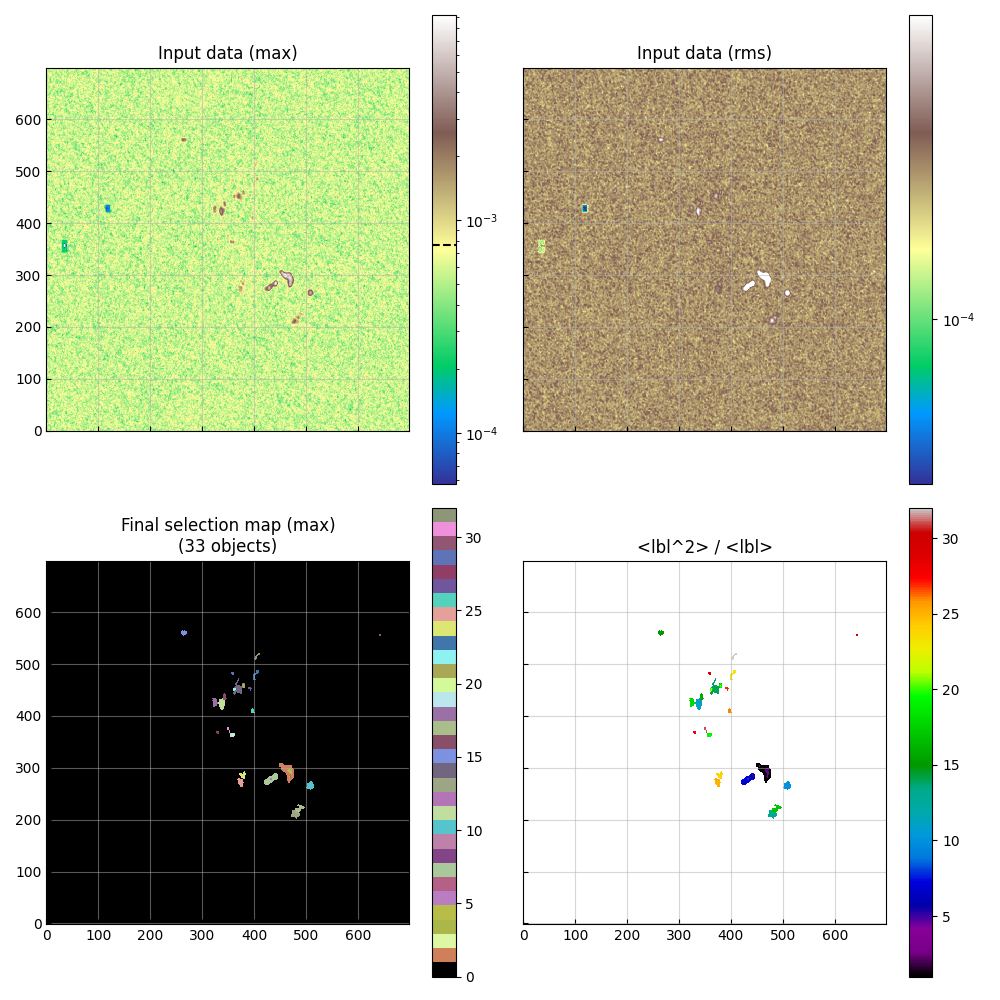

In [36]:
if data_dimensionality == 3:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data-data_mode, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colors.LogNorm(vmin=np.nanpercentile(data, 60))
    )
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-data_mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        norm = colors.SymLogNorm(vmin=np.nanpercentile(data, 60), linthresh=delta_th/10, vmax=np.nanpercentile(data, 99))
    )
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        np.nanmax(final_selection, axis=0),
        interpolation='nearest', origin='lower', cmap=final_selection.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


/tmp/ipykernel_108282/599121326.py:27: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(section_labels**2, axis=2).T / np.nansum(section_labels, axis=2).T,
/tmp/ipykernel_108282/599121326.py:68: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(section_labels**2, axis=1).T / np.nansum(section_labels, axis=1).T,
/home/yago/.local/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.figure.savefig(buf, format='png', dpi='figure')


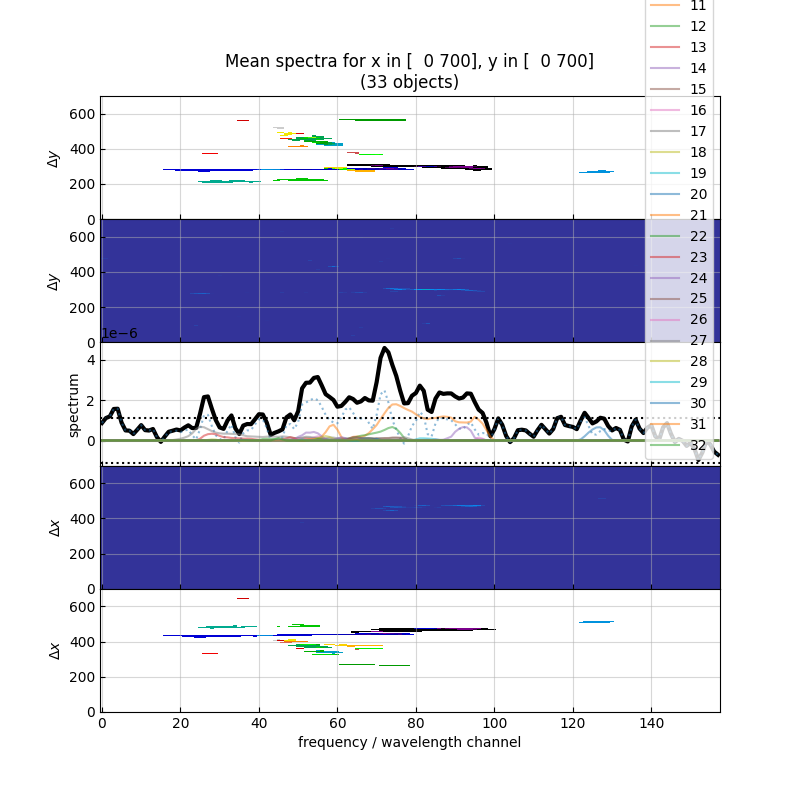

In [37]:
if data_dimensionality == 3:
    lo = np.nanpercentile(data, 60)
    hi = np.nanpercentile(data, 99)
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        np.nansum(section_labels**2, axis=2).T / np.nansum(section_labels, axis=2).T,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = bg_std /np.sqrt(section.shape[1]*section.shape[2])
    factor = delta_th/bg_std
    ax[2, 0].axhline(factor*mean_error, c='k', ls=':')
    ax[2, 0].axhline(-factor*mean_error, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        np.nansum(section_labels**2, axis=1).T / np.nansum(section_labels, axis=1).T,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


In [38]:
hdu = fits.PrimaryHDU(final_labels)
hdu.writeto('HOT_labels.fits', overwrite=True)

In [39]:
x = [10, 22, 20, 30, 10, 0, 1, 2]
xids = [1, 1, 0, 0, 2, 2, 2, 3]
s = np.zeros(4)
np.add.at(s, xids, x)
print(s)

[50. 32. 11.  2.]
